<a href="https://colab.research.google.com/github/Starksood/Experimental_Conundrums/blob/main/CH10_HYperparameterTuning_with_KerasTuner.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
try:
  %tensorflow_version 2.x
except Exception:
  pass  

In [2]:
!pip install keras-tuner

     |████████████████████████████████| 98 kB 3.6 MB/s 


In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.version)

<module 'tensorflow._api.v2.version' from '/usr/local/lib/python3.7/dist-packages/tensorflow/_api/v2/version/__init__.py'>


In [11]:
from kerastuner.tuners import randomsearch

In [6]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 20
slope = 0.09
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000


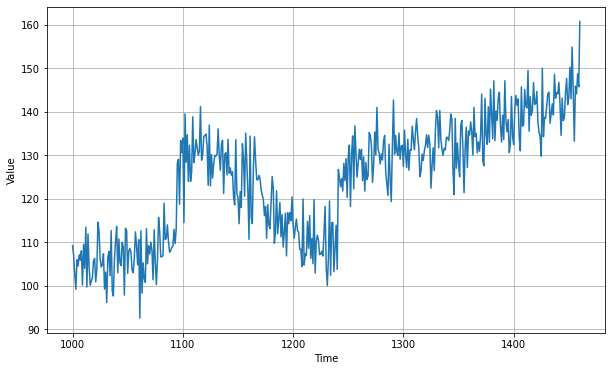

In [7]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)

In [8]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset


In [13]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

def build_model(hp):
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Dense(units=hp.Int('units', min_value=10, max_value=30, step=2), activation='relu', input_shape=[window_size]))
  model.add(tf.keras.layers.Dense(10, activation='relu'))
  model.add(tf.keras.layers.Dense(1))

  model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(hp.Choice('momentum', values=[.9, .7, .5, .3]), lr=1e-5))
  return model

tuner = RandomSearch(build_model, objective='loss', max_trials=50, executions_per_trial=3, directory='my_dir', project_name='hello')

tuner.search_space_summary()

tuner.search(dataset, epochs=100, verbose=0)

NameError: ignored

In [15]:
#models = tuner.get_best_models(num_models=4)
tuner.results_summary()
#print(models)


NameError: ignored

In [16]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(28, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.5)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset, epochs=100,  verbose=1)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/100
31/31 [==============================] - 1s 4ms/step - loss: 191.8899
Epoch 2/100
31/31 [==============================] - 0s 2ms/step - loss: 44.7678
Epoch 3/100
31/31 [==============================] - 0s 2ms/step - loss: 42.6772
Epoch 4/100
31/31 [==============================] - 0s 2ms/step - loss: 41.7504
Epoch 5/100
31/31 [==============================] - 0s 3ms/step - loss: 42.1314
Epoch 6/100
31/31 [==============================] - 0s 3ms/step - loss: 41.0475
Epoch 7/100
31/31 [==============================] - 0s 3ms/step - loss: 41.1008
Epoch 8/100
31/31 [==============================] - 0s 3ms/step - loss: 40.5559
Epoch 9/100
31/31 [==============================] - 0s 2ms/step - loss: 39.3094
Epoch 10/100
31/31 [==============================] - 0s 2ms/step - loss: 40.3120
Epoch 11/100
31/31 [==============================] - 0s 2ms/step - loss: 38.7803
Epoch 12/100
31/31 [==============================] - 0s 2ms/step - loss: 38.9116
Epoch 13/100
31/31 [====

In [14]:
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

NameError: ignored

In [17]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

NameError: ignored